In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
"""Test reparam of curves that are not equivqalent """
import torch
from torch.utils.data import TensorDataset

# torch.set_default_dtype(torch.float64)
import matplotlib.pyplot as plt
import numpy as np
from deepthermal.FFNN_model import fit_FFNN, FFNN, init_xavier
from deepthermal.validation import create_subdictionary_iterator, k_fold_cv_grid, add_dictionary_iterators

from deepthermal.plotting import plot_result, plot_model_1d

from deep_reparametrization.plotting import plot_reparametrization
from deep_reparametrization.reparametrization import (
    get_elastic_metric_loss,
    compute_loss_reparam,
    get_elastic_error_func,
)
from deep_reparametrization.ResNET import ResNET
import test.curves as c1

In [23]:
########
PATH_FIGURES = "../figures/curve_1"
########

SET_NAME = "curve_1_exp_1"

FOLDS = 1
N = 128  # training points internal

loss_func = get_elastic_metric_loss(r=c1.r, constrain_cost=1e3, verbose=False)
MODEL_PARAMS = {
    "model": [ResNET, FFNN],
    "input_dimension": [1],
    "output_dimension": [1],
    "activation": ["tanh"],
    "n_hidden_layers": [1, 2, 4, 16, 32, 64],
}
# extend the previous dict with the zip of this
MODEL_PARAMS_EXPERIMENT = {
    "neurons": [4, 8, 16, 32, 64, 128],
}
TRAINING_PARAMS = {
    "batch_size": [N],
    "regularization_param": [1e-8],
    "compute_loss": [compute_loss_reparam],
    "loss_func": [loss_func],
}
# extend the previous dict with the zip of this
TRAINING_PARAMS_EXPERIMENT = {
    "optimizer": ["strong_wolfe"],
    "num_epochs": [1],
    "learning_rate": [ 0.01],
}

In [24]:
# Load data
x_train = torch.linspace(0, 1, N, requires_grad=True).unsqueeze(1)
q_train = c1.q(x_train.detach())


data = TensorDataset(x_train, q_train)

model_params_iter = create_subdictionary_iterator(MODEL_PARAMS)
model_exp_iter = create_subdictionary_iterator(MODEL_PARAMS_EXPERIMENT, product=False)
exp_model_params_iter = add_dictionary_iterators(model_exp_iter, model_params_iter)

training_params_iter = create_subdictionary_iterator(TRAINING_PARAMS)
training_exp_iter = create_subdictionary_iterator(TRAINING_PARAMS_EXPERIMENT, product=False)
exp_training_params_iter = add_dictionary_iterators(training_exp_iter, training_params_iter)

Do the actual training

In [25]:
cv_results = k_fold_cv_grid(
    model_params=exp_model_params_iter,
    fit=fit_FFNN,
    training_params=exp_training_params_iter,
    data=data,
    folds=FOLDS,
    verbose=True,
    trials=5
)


Running model (trial=0, mod=0, k=0):
################################  0  ################################
Training Loss:  0.00717711
Validation Loss:  0.00717711
Final Training Loss:  0.00717711
Final Validation Loss:  0.00717711

Running model (trial=0, mod=1, k=0):
################################  0  ################################
Training Loss:  0.01159034
Validation Loss:  0.01159034
Final Training Loss:  0.01159034
Final Validation Loss:  0.01159034

Running model (trial=0, mod=2, k=0):
################################  0  ################################
Training Loss:  0.00587765
Validation Loss:  0.00587765
Final Training Loss:  0.00587765
Final Validation Loss:  0.00587765

Running model (trial=0, mod=3, k=0):
################################  0  ################################
Training Loss:  91.77373505
Validation Loss:  91.77371979
Final Training Loss:  91.77373505
Final Validation Loss:  91.77371979

Running model (trial=0, mod=4, k=0):
##############################

FileNotFoundError: [Errno 2] No such file or directory: '../figures/curve_1/history_curve_1_exp_1_0.pdf'

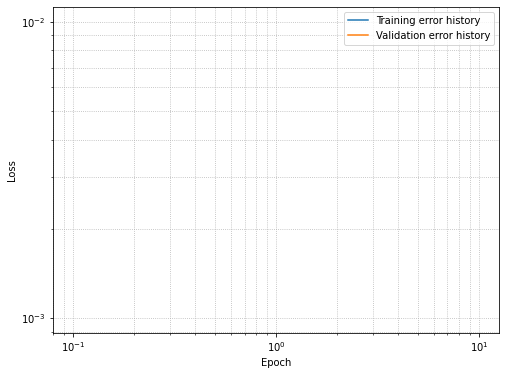

In [26]:
# plotting
x_train_ = x_train.detach()
x_sorted, indices = torch.sort(x_train_, dim=0)

plot_kwargs = {
    "x_test": x_sorted,
    "x_train": x_sorted,
    "y_train": c1.ksi(x_sorted),
    "x_axis": "t",
    "y_axis": "$\\xi(t)$",
}
plot_result(
    path_figures=PATH_FIGURES,
    plot_name=SET_NAME,
    **cv_results,
    plot_function=plot_model_1d,
    function_kwargs=plot_kwargs,
)

In [ ]:

models = cv_results["models"]

parameters = np.vectorize(lambda model: sum(p.numel() for p in model.parameters()))(models)
model_type = np.vectorize(lambda model: 0 if isinstance(model,ResNET) else 1)(models)
layers = np.vectorize(lambda model: model.n_hidden_layers)(models)
neurons = np.vectorize(lambda model: model.neurons)(models)
loss_array = np.vectorize(lambda model: loss_func(model, x_train, q_train).detach())(models)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(layers,loss_array)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Error")
ax.set_xlabel("Layers")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(parameters,loss_array)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Error")
ax.set_xlabel("Number of parameters")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(neurons,loss_array)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Error")
ax.set_xlabel("Neurons per layer")
plt.show()

In [ ]:
import seaborn as sns

fmri = sns.load_dataset("fmri")
sns.relplot(x=parameters.ravel(), y=loss_array.ravel(), kind="line");


